# Autograd: automatic differentiation

When executing tensor operations, PyTorch can automatically construct on-the-fly the graph of operations to compute the gradient of any quantity with respect to any tensor involved.

More information on autotomatic differentiation in Pytorch [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

## Visualizing the computational graph

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

PyTorchViz is a small package to create visualizations of PyTorch execution graphs and traces.

In [3]:
!pip install torchviz

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mxnet 1.7.0.post1 requires graphviz<0.9.0,>=0.8.1, but you have graphviz 0.16 which is incompatible.
mxnet 1.7.0.post1 requires numpy<1.17.0,>=1.8.2, but you have numpy 1.20.2 which is incompatible.
mxnet 1.7.0.post1 requires requests<2.19.0,>=2.18.4, but you have requests 2.25.1 which is incompatible.



  Using cached torchviz-0.0.2-py3-none-any.whl
  Using cached graphviz-0.16-py2.py3-none-any.whl (19 kB)


In [26]:
!pip install graphviz

In [2]:
import torchviz

Inn order to enable automatic differentiation, PyTorch keeps track of all operations involving tensors for which the gradient may need to be computed (i.e., require_grad is True). The operations are recorded as a directed graph. 

Torch tensors are recalled [here](https://pytorch.org/docs/stable/tensors.html) 



In [3]:
x = torch.ones(2, 2)
print(x)

tensor([[1., 1.],
        [1., 1.]])


A Tensor has a Boolean field *requires_grad*, set to False by default, which states if PyTorch should build the graph of operations so that gradients wrt to it can be computed.

In [4]:
x.requires_grad

False

In [5]:
x.numpy()

array([[1., 1.],
       [1., 1.]], dtype=float32)

In [6]:
x.requires_grad_(True)
x.requires_grad

True

### Question: The following cell gives an error. Why?

In [7]:
x.numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

The detach() method constructs a new view on a tensor which is declared not to need gradients, i.e., it is to be excluded from further tracking of operations, and therefore the subgraph involving this view is not recorded.

In [ ]:
x.detach().numpy()

In [ ]:
x.data.numpy() # Torch.data returns the "data" (array_like) stored in the tensor

In [ ]:
x.requires_grad

In [ ]:
y = x + 2
print(y)
torchviz.make_dot(y)

**Broadcasting**

Recall: Broadcasting **automatically** expands dimensions by replicating coefficients, when it is necessary to perform operations.

1. If one of the tensors has fewer dimensions than the other, it is reshaped by adding as many dimensions of size 1 as necessary in the front; then
2. for every mismatch, if one of the two tensor is of size one, it is expanded along this axis by replicating  coefficients.

If there is a tensor size mismatch for one of the dimension and neither of them is one, the operation fails.

In [ ]:
A = torch.tensor([[1.], [2.], [3.], [4.]])
print(A.size())
print(A)
B = torch.tensor([[5., -5., 5., -5., 5.]])
print(B.size())
print(B)
C = A + B
print(C)

Back to Autograd!

In [ ]:
x = torch.ones(2, 2)
x.requires_grad_(True)
y = x+2
print(y)

In [ ]:
y.requires_grad

Tensor and Function are interconnected and build up an acyclic graph, that encodes a complete history of computation. 

Each tensor has a .grad_fn attribute that references a Function that has created the Tensor (except for Tensors created by the user - their grad_fn is None).

In [ ]:
print(x)
print(x.grad_fn)
print(y)
print(y.grad_fn)
torchviz.make_dot(y) 

In [ ]:
z = y * y * 3
print(z)
torchviz.make_dot(z) 

In [ ]:
out = z.mean()
print(out)
torchviz.make_dot(out) 

After the computation is finished, i.e. _forward pass_, you can call ```.backward()``` and have all the gradients computed automatically.

In [ ]:
out.backward()

The gradients w.r.t. this variable is accumulated into ```.grad```.

In [ ]:
print(x.grad)

$\frac{\partial out}{\partial x} = \frac{1}{4} \sum_{i=1}^4 (x_i+2)^2 \times 3$

### Question: Explain mathematically the value of "x.grad"


[Why can I not see .grad of an intermediate variable?](https://discuss.pytorch.org/t/why-cant-i-see-grad-of-an-intermediate-variable/94)

Gradients are only retained for leaf variables. 

Non-leaf variables’ gradients are not retained to be inspected later. This was done by design, to save memory.

In [ ]:
print(y.grad)
print(out.grad)

In [ ]:
x = 2 * torch.ones(2, 2)
print(x)
x.requires_grad_(True)
out = (x * x * x + 2 ).mean()
print(out)
torchviz.make_dot(out)

In [ ]:
out.backward(torch.tensor(2.0))

### Question: Explain mathematically the value of "x.grad" in the following cell

In [ ]:
print(x.grad)

## How to compute the gradient when I want?



In [ ]:
x = torch.ones(2, 2)
x.requires_grad_(True)
y = x+2
z = 3 * y ** 2 
out = z.mean()

out.backward(retain_graph=True)

print(x.grad)

Calling again the "backward" process does not launch an error

In [ ]:
out.backward()

In [ ]:
print(x.grad)

In [ ]:
torch.autograd.grad(out, out, retain_graph=True)

In [ ]:
torch.autograd.grad(out, z, retain_graph=True)

In [ ]:
torch.autograd.grad(out, y, retain_graph=True)

In [ ]:
out.backward(torch.tensor(2.0), retain_graph=True)

In [ ]:
print(x.grad)

## A last example

In [ ]:
x=torch.ones(10, requires_grad=True)

y=x**2
z=x**3
r=(y+z).sum()

r.backward()
print(x.grad)
torchviz.make_dot(r) 

## Gradient accumulation


The gradients must be set to zero manually. Otherwise they will cumulate across several _.backward()_ calls. 
This accumulating behavior is desirable in particular to compute the gradient of a loss summed over several “mini-batches,” or the gradient of a sum of losses.


In [ ]:
x = torch.ones(1, 1,requires_grad = True)
out = (x+1)**2
print(out)

In [ ]:
out.backward(torch.ones(1,1),retain_graph=True)
print(x.grad)
out.backward(2 * torch.ones(1,1),retain_graph=True)
print(x.grad)
out.backward(retain_graph=True)
print(x.grad)

In [ ]:
# Manually zero the gradients after updating weights
x.grad.data.zero_()

In [ ]:
out.backward(torch.ones(1,1),retain_graph=True)
print(x.grad)
x.grad.data.zero_()
out.backward(2 * torch.ones(1,1),retain_graph=True)
print(x.grad)
x.grad.data.zero_()
out.backward(retain_graph=True)
print(x.grad)


If you want to come back to the difference between detach and data see [Differences between .data and .detach](https://github.com/pytorch/pytorch/issues/6990)

# Playing with a neural network in pytorch: non-linear regression

## Non-linear regression with a neural network

An implementation of **(Batch) Gradient Descent** using the nn package. Here we have a super simple model with only one layer and no activation function!

Generate the dataset and visualize it.

In [ ]:
! jt -t monokai

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


# Make data
num_samples = 10
X1 = np.linspace(-5, 5, num_samples) 
X2 = np.linspace(-5, 5, num_samples) 
X1grid, X2grid = np.meshgrid(X1, X2)
Y = -(0.1*X1grid**2 + 3*np.sin(0.1*X2grid) + 0.1) 

#print(X1grid)
#print(X2grid)
#print(Y)

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X1grid, X2grid, Y, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [71]:
x1n = X1grid.ravel().reshape(-1, 1)
x2n = X2grid.ravel().reshape(-1, 1)
xn = np.concatenate((x1n,x2n),axis=1)
yn = Y.ravel().reshape(-1, 1)
#print(x1n.shape)
#print(x2n.shape)
print(xn.shape)
print(yn.shape)

# Convert in pytorch tensors
x = torch.from_numpy(xn).float()
y = torch.from_numpy(yn).float()
#print(x)
#print(y)
print(x.shape)

(100, 2)
(100, 1)
torch.Size([100, 2])


## Neural network with full implementation (gradient computation and estimate update)

In [72]:
import torch

dtype = torch.float

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = num_samples**2, 2, 100, 1

# Randomly initialize weights
w1 = torch.randn(D_in, H, dtype=dtype)
w2 = torch.randn(H, D_out,  dtype=dtype)

learning_rate = 1e-6 
for t in range(10001):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)
    #print(y_pred)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 1000 == 0:
        print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

0 121066.8125
1000 16.765317916870117
2000 12.187544822692871
3000 10.25378704071045
4000 9.030571937561035
5000 8.189521789550781
6000 7.579919815063477
7000 7.147266387939453
8000 6.812748908996582
9000 6.547571659088135
10000 6.346971035003662


Compare the first values

In [73]:
print(y[0:5])
print(y_pred[0:5])

tensor([[-1.1617],
        [-0.1741],
        [ 0.5667],
        [ 1.0605],
        [ 1.3074]])
tensor([[-0.7440],
        [ 0.1812],
        [ 0.4789],
        [ 1.0299],
        [ 1.3936]])


Plot the approximation in 1D

In [74]:
def plotApproximation(y,y_pred):
  plt.figure(figsize=(6, 4))
  plt.plot(y.detach().numpy(),'b-')
  plt.plot(y_pred.detach().numpy(),'r-*')
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.title('Approximation with the neural network')
  plt.show()

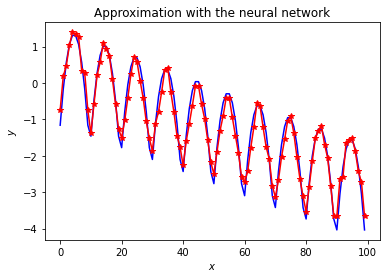

In [75]:
plotApproximation(y,y_pred)

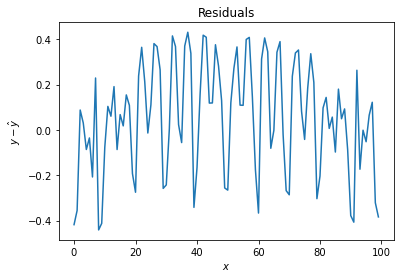

In [76]:
plt.figure(figsize=(6, 4))
plt.plot(y.numpy()-y_pred.numpy())
plt.title('Residuals')
plt.xlabel('$x$')
plt.ylabel('$y-\hat{y}$')
plt.show()

Last step, we use directly the optim package to update the weights and bias.

## Neural network with automatic gradient computation (but still the explicit estimate update)


A fully-connected ReLU network with one hidden layer, trained to predict y from x
by minimizing squared Euclidean distance.

This implementation uses the nn package from PyTorch to build the network.
PyTorch autograd makes it easy to define computational graphs and take gradients,
but raw autograd can be a bit too low-level for defining complex neural networks;
this is where the nn package can help. The nn package defines a set of Modules,
which you can think of as a neural network layer that has produces output from
input and may have some trainable weights.

### Question: use autograd to compute the gradient. You can start from the full implementation of the neural network.

In [77]:
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = num_samples**2, 2, 100, 1

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-6
for t in range(30001):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 1000 == 0:
        print(t, loss.item())
    
    model.zero_grad()
    
    # Backprop to compute gradients of w1 and w2 with respect to loss
    loss.backward()
    
    with torch.no_grad():
        for param in model.parameters():
            param-=learning_rate*param.grad


    # Update weights using gradient descent
# You can access the first layer of `model` like accessing the first item of a list
linear_layer = model[0]

0 311.402587890625
1000 17.605052947998047
2000 9.39195442199707
3000 7.228336811065674
4000 6.2508440017700195
5000 5.602488994598389
6000 5.104543209075928
7000 4.705657005310059
8000 4.3820109367370605
9000 4.117582321166992
10000 3.9008214473724365
11000 3.722101926803589
12000 3.573742151260376
13000 3.449544668197632
14000 3.3450725078582764
15000 3.256483316421509
16000 3.180771589279175
17000 3.1154708862304688
18000 3.05859637260437
19000 3.0087428092956543
20000 2.964635133743286
21000 2.9252147674560547
22000 2.8897287845611572
23000 2.857513427734375
24000 2.8280463218688965
25000 2.800852060317993
26000 2.775580644607544
27000 2.751920461654663
28000 2.7296791076660156
29000 2.708667278289795
30000 2.6887784004211426


In [78]:
loss_fn(y_pred, y)

tensor(2.6888, grad_fn=<MseLossBackward>)

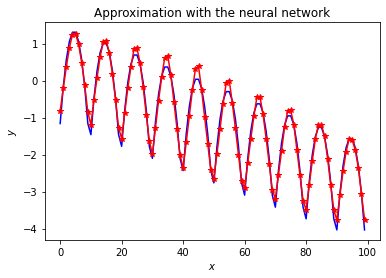

In [79]:
plotApproximation(y,y_pred)

## Neural network with automatic gradient computation and automatic estimate update

A fully-connected ReLU network with one hidden layer, trained to predict y from x
by minimizing squared Euclidean distance.

This implementation uses the nn package from PyTorch to build the network.

Rather than manually updating the weights of the model as we have been doing,
we use the optim package to define an Optimizer that will update the weights
for us. The optim package defines many optimization algorithms that are commonly
used for deep learning, including SGD+momentum, RMSProp, Adam, etc.

### Question: use the Torch optimizer to do the gradient descent. You can start from the full implementation of the neural network with automatic differentiation.

Details on Optimizer are [here](https://pytorch.org/docs/stable/optim.html)

In [80]:
!pip install madgrad

In [81]:
from madgrad import MADGRAD

In [82]:
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = num_samples**2, 2, 100, 1

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-6
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
adam = torch.optim.Adam(model.parameters(), lr=learning_rate)
madgrad=MADGRAD(model.parameters(), lr=learning_rate)
for t in range(10001):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 1000 == 0:
        print(t, loss.item())

    # COMPLETE THE CODE FROM HERE
    madgrad.zero_grad()
    # Backward pass: Compute the gradient of the loss with respect to the each parameters
    loss.backward()
    
    madgrad.step()

0 369.97113037109375
1000 2.0424258708953857
2000 1.3561652898788452
3000 0.7961938977241516
4000 0.424096018075943
5000 0.24008367955684662
6000 0.14787697792053223
7000 0.08288352191448212
8000 0.0458986759185791
9000 0.027339953929185867
10000 0.01864611729979515


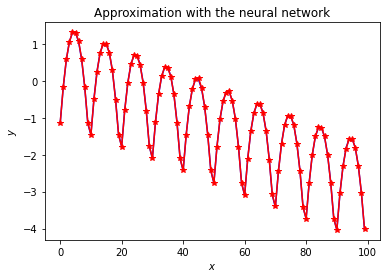

In [83]:
plotApproximation(y,y_pred)

In [87]:
y.detach().numpy()

array([[-1.1617234 ],
       [-0.17406906],
       [ 0.56667167],
       [ 1.0604988 ],
       [ 1.3074124 ],
       [ 1.3074124 ],
       [ 1.0604988 ],
       [ 0.56667167],
       [-0.17406906],
       [-1.1617234 ],
       [-1.4625185 ],
       [-0.47486416],
       [ 0.26587656],
       [ 0.75970376],
       [ 1.0066173 ],
       [ 1.0066173 ],
       [ 0.75970376],
       [ 0.26587656],
       [-0.47486416],
       [-1.4625185 ],
       [-1.7773421 ],
       [-0.7896878 ],
       [-0.04894707],
       [ 0.4448801 ],
       [ 0.6917937 ],
       [ 0.6917937 ],
       [ 0.4448801 ],
       [-0.04894707],
       [-0.7896878 ],
       [-1.7773421 ],
       [-2.1023116 ],
       [-1.1146573 ],
       [-0.37391654],
       [ 0.11991062],
       [ 0.3668242 ],
       [ 0.3668242 ],
       [ 0.11991062],
       [-0.37391654],
       [-1.1146573 ],
       [-2.1023116 ],
       [-2.433419  ],
       [-1.4457648 ],
       [-0.705024  ],
       [-0.21119682],
       [ 0.03571675],
       [ 0

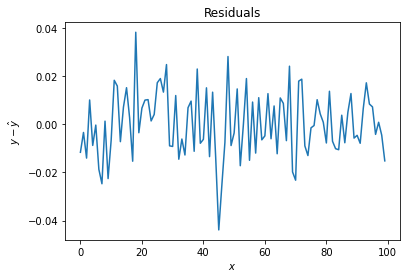

In [88]:
plt.figure(figsize=(6, 4))
plt.plot(y.detach().numpy()-y_pred.detach().numpy())
plt.title('Residuals')
plt.xlabel('$x$')
plt.ylabel('$y-\hat{y}$')
plt.show()